In [1]:
import os
print(sys.executable)

/Users/jervermindah/opt/anaconda3/envs/tf/bin/python


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import librosa as lb
import librosa.display
import os

import IPython
import IPython.display as ipd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import visualkeras

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## The Dataset - GTZAN

- Instances (m): 1,000
- Squence length (per instance): 30 sec
- Labels: 10 (Blues, Classical, Country, Disco, Hip hop, Jazz, Metal, Pop, Reggae, Rock)

Preparing the dataset 
>Download it GTZAN dataset from kaggle


### Steps
1. Create the dataset. Feature Engineering
2. Fit the CNN to the dataset
3. Evaluate the performance

## 1. Setup, Data, Feature Engineering

In [153]:
import pandas as pd
music_genres = pd.read_csv('Data/features_30_sec.csv')


In [55]:
path = './data/genres_original/'
labels = [f.name for f in os.scandir(path) if f.is_dir()]

indices = [i for i in range(len(labels))]
depth = len(labels)
oh = tf.one_hot(indices, depth)
oh_dict = {label:np.array(oh[i,:]) for i, label in enumerate(labels)}

print(labels)
for k, v in oh_dict.items():
    print(k,v)

n_files = 0
for folder in labels:
    files = os.listdir(path+folder)
    for file in files:
        if file.split('.')[-1] == 'wav':
            n_files += 1
print(f'n_files: {n_files}')

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
pop [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
metal [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
disco [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
blues [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
reggae [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
classical [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
rock [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
hiphop [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
country [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
jazz [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
n_files: 1000


In [6]:
indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [7]:
depth

10

In [8]:
oh

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [9]:
oh_dict

{'pop': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'metal': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'disco': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'blues': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'reggae': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 'classical': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 'rock': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 'hiphop': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 'country': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32),
 'jazz': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)}

In [25]:
# Global variables
n_files = 999
H = 128 # height of the tensor

N_FEATURES = 1 # Channels of the tensor
N_FILES = n_files
AUG_FEATURES = 5
N_SLICES = 3
M = N_FILES * N_SLICES * (AUG_FEATURES + 1) # Number of instances after the feature transform
KMM = N_SLICES * (AUG_FEATURES + 1)


In [47]:
def read_sample(file):
    y, sr = lb.load(file)
    return y, sr

def listen_sample(sample, sr=44100):
    return IPython.display.display(ipd.Audio(data=sample, rate=sr))


def augment_sample(sample, sr):
    
    #Data augmentation. To prevent overfitting
    #Techniques used: pitch shift, time stretch, add noise
    
    augmented_samples = list()
    #. 1. Split the sample into smaller samples
    samples = np.array_split(sample, N_SLICES)
    
    for sample_ in samples:
        # 2. Add the original sample
        augmented_samples.append(sample_)
        # 3. Change pitch
        for n_steps in [4,6]:
            augmented_samples.append(lb.effects.pitch_shift(sample_, sr,n_steps))

        # 4. Time Stretch
        for rate in [0.5, 2.0]:
            augmented_samples.append(lb.effects.time_stretch(sample_, rate))

        # 5. White Noise
        wn = np.random.randn(len(sample_))
        augmented_samples.append(sample_ + 0.005*wn)
    
    return augmented_samples

def get_input_length(path, folders):
    #Get the input length from the first file
    folder = folders[0]
    files = os.listdir(path+folder)
    input_length = 0
    for file in files:
        if file.split('.')[-1] == 'wav':
            sample, sr = read_sample(path+folder+'/'+file)
            input_length = len(sample) // N_SLICES
            break
        
    
    return input_length


def get_n_frames(sample, sr):
    mel = lb.feature.melspectrogram(sample, sr)
    return mel.shape[1]
    
    
def read_raw_data(path, folders):
    input_length = get_input_length(path, folders)
    print(input_length)
    x_raw = np.zeros((M, input_length))
    y_raw = np.zeros((M, 10))
    print(x_raw.shape, y_raw.shape)
    i = 0
    for folder in folders:
        print(f"Reading {folder}")
        files = os.listdir(path+folder)
        for file in files:
            
            # make sure the file is a .wav file
            if file.split('.')[-1] == 'wav':
                sample, sr = read_sample(path+folder+'/'+file)
                aug_samples = augment_sample(sample, sr)
                for sample_ in aug_samples: 
                    # padding or shorten sample
                    if len(sample_) > input_length:
                        sample_ = sample_[:input_length]
                    else:
                        sample_ = np.pad(sample_, (0, max(0, input_length - len(sample_))))
                    x_raw[i,:] = sample_
                    y_raw[i,:] = oh_dict[folder]
                    i += 1
    print('Samples read: ', i)
    return x_raw, y_raw, sr


def create_dataset(x_raw, sr):
    n_frames = get_n_frames(x_raw[0,:], sr)
    X = np.zeros((M, 128, n_frames, N_FEATURES))

    for i in range(M):
        sample = x_raw[i,:]
        mel = lb.feature.melspectrogram(sample, sr)
        spect = lb.power_to_db(mel, ref=1.0)
        norm_spect = normalize(spect)
        X[i,:,:,0] = norm_spect  
    return X



In [ ]:
x_raw, y_raw, sr = read_raw_data(path, labels)
print(x_raw.shape, y_raw.shape)

In [15]:
np.save('../x_raw_3_slice.npy', x_raw)
np.save('../y_raw_3_slice.npy', y_raw)

NameError: name 'x_raw' is not defined

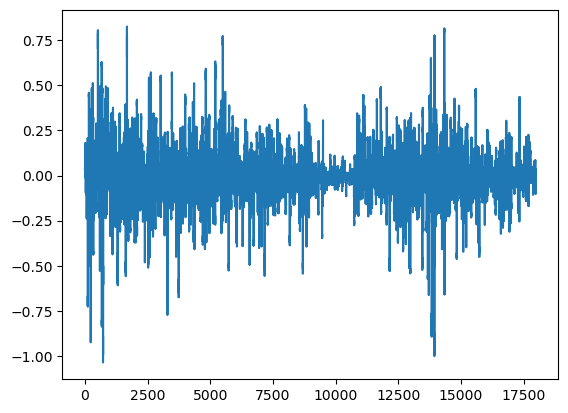

In [10]:
plt.plot(x_raw[:,0])

In [16]:
# Run only if we are loading the data

x_raw = np.load('../x_raw_3_slice.npy',allow_pickle=True)
y_raw = np.load('../y_raw_3_slice.npy',allow_pickle=True)

_,sr = read_sample(path+'blues/'+'blues.00000.wav')

In [11]:
print(x_raw)
print('------------------')
print(y_raw)

[[ 0.03451538  0.04815674  0.06430054 ...  0.00454712  0.02124023
   0.0305481 ]
 [ 0.03072549  0.05194006  0.07957102 ...  0.06115969  0.04717612
   0.03357912]
 [ 0.02958532  0.05419713  0.09009463 ... -0.13302737 -0.13990349
  -0.13674988]
 ...
 [ 0.03763523  0.03975102  0.0422758  ... -0.16385396 -0.09957685
  -0.05448074]
 [ 0.03573344  0.03945865  0.04043274 ...  0.          0.
   0.        ]
 [ 0.0306551   0.03985512  0.05153272 ... -0.01923482 -0.00646402
   0.00083877]]
------------------
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
X = create_dataset(x_raw, sr)
Y = np.copy(y_raw)
print(X.shape)
print(Y.shape)

In [23]:
pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("Y.pickle","wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

In [ ]:
#load X,Y
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [24]:
assert X.shape[0] == Y.shape[0], "X, Y shapes don't match"
assert Y.shape[1] == len(labels), "Y shape doesn't match the shape of the labels"

In [25]:
x_train, x_test_valid, y_train, y_test_valid = train_test_split(X,Y, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_test_valid,y_test_valid, test_size=0.5)

print(f'Train: {x_train.shape} {y_train.shape}')
print(f'Valid: {x_val.shape}   {y_val.shape}')
print(f'Test:  {x_test.shape}  {y_test.shape}')


Train: (14385, 128, 431, 1) (14385, 10)
Valid: (1798, 128, 431, 1)   (1798, 10)
Test:  (1799, 128, 431, 1)  (1799, 10)


## 2. Modeling: CNN


### CNN-64

In [26]:
n_filters = 64
input_shape = (X.shape[1], X.shape[2], X.shape[3])
inputs = keras.Input(shape=input_shape) 
x = preprocessing.Resizing(128, 128)(inputs)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)


x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation='softmax')(x)

In [12]:
n_filters = 64
inputs = keras.Input(shape=input_shape) 
x = layers.Conv2D(n_filters, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

In [27]:
 model = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 431, 1)]     0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                             

In [14]:
epochs = 20

history = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    shuffle=True)

Epoch 1/20
450/450 [==============================] - 659s 1s/step - loss: 1.7667 - accuracy: 0.3670 - val_loss: 1.4427 - val_accuracy: 0.5067
Epoch 2/20
450/450 [==============================] - 636s 1s/step - loss: 1.2402 - accuracy: 0.5620 - val_loss: 1.2045 - val_accuracy: 0.5662
Epoch 3/20
450/450 [==============================] - 634s 1s/step - loss: 0.9887 - accuracy: 0.6550 - val_loss: 0.9316 - val_accuracy: 0.6813
Epoch 4/20
450/450 [==============================] - 628s 1s/step - loss: 0.8002 - accuracy: 0.7237 - val_loss: 0.8226 - val_accuracy: 0.7113
Epoch 5/20
450/450 [==============================] - 658s 1s/step - loss: 0.6724 - accuracy: 0.7692 - val_loss: 0.7731 - val_accuracy: 0.7380
Epoch 6/20
450/450 [==============================] - 628s 1s/step - loss: 0.5547 - accuracy: 0.8111 - val_loss: 0.6875 - val_accuracy: 0.7659
Epoch 7/20
450/450 [==============================] - 635s 1s/step - loss: 0.4840 - accuracy: 0.8341 - val_loss: 0.6471 - val_accuracy: 0.7903

In [15]:
history2 = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=(x_val, y_val),
                    initial_epoch=20,
                    epochs=50,
                    shuffle=True)

Epoch 21/50
450/450 [==============================] - 653s 1s/step - loss: 0.2223 - accuracy: 0.9248 - val_loss: 0.5682 - val_accuracy: 0.8326
Epoch 22/50
450/450 [==============================] - 647s 1s/step - loss: 0.2125 - accuracy: 0.9265 - val_loss: 0.5850 - val_accuracy: 0.8443
Epoch 23/50
450/450 [==============================] - 640s 1s/step - loss: 0.2168 - accuracy: 0.9263 - val_loss: 0.5653 - val_accuracy: 0.8493
Epoch 24/50
450/450 [==============================] - 631s 1s/step - loss: 0.2020 - accuracy: 0.9313 - val_loss: 0.6118 - val_accuracy: 0.8354
Epoch 25/50
450/450 [==============================] - 744s 2s/step - loss: 0.1851 - accuracy: 0.9359 - val_loss: 0.6130 - val_accuracy: 0.8393
Epoch 26/50
450/450 [==============================] - 612s 1s/step - loss: 0.1934 - accuracy: 0.9326 - val_loss: 0.6262 - val_accuracy: 0.8309
Epoch 27/50
450/450 [==============================] - 675s 2s/step - loss: 0.1793 - accuracy: 0.9394 - val_loss: 0.7240 - val_accuracy:

In [16]:
history3 = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=(x_val, y_val),
                    initial_epoch=50,
                    epochs=100,
                    shuffle=True)

Epoch 51/100
450/450 [==============================] - 647s 1s/step - loss: 0.1359 - accuracy: 0.9534 - val_loss: 0.5732 - val_accuracy: 0.8565
Epoch 52/100
450/450 [==============================] - 640s 1s/step - loss: 0.1315 - accuracy: 0.9568 - val_loss: 0.5667 - val_accuracy: 0.8626
Epoch 53/100
450/450 [==============================] - 898s 2s/step - loss: 0.1332 - accuracy: 0.9562 - val_loss: 0.5679 - val_accuracy: 0.8582
Epoch 54/100
450/450 [==============================] - 625s 1s/step - loss: 0.1358 - accuracy: 0.9555 - val_loss: 0.5914 - val_accuracy: 0.8587
Epoch 55/100
450/450 [==============================] - 606s 1s/step - loss: 0.1354 - accuracy: 0.9547 - val_loss: 0.5808 - val_accuracy: 0.8676
Epoch 56/100
450/450 [==============================] - 609s 1s/step - loss: 0.1249 - accuracy: 0.9600 - val_loss: 0.6005 - val_accuracy: 0.8593
Epoch 57/100
450/450 [==============================] - 625s 1s/step - loss: 0.1250 - accuracy: 0.9581 - val_loss: 0.5908 - val_ac

In [68]:
model.evaluate(x=x_test, y=y_test)

NameError: name 'x_test' is not defined

57/57 [==============================] - 15s 262ms/step


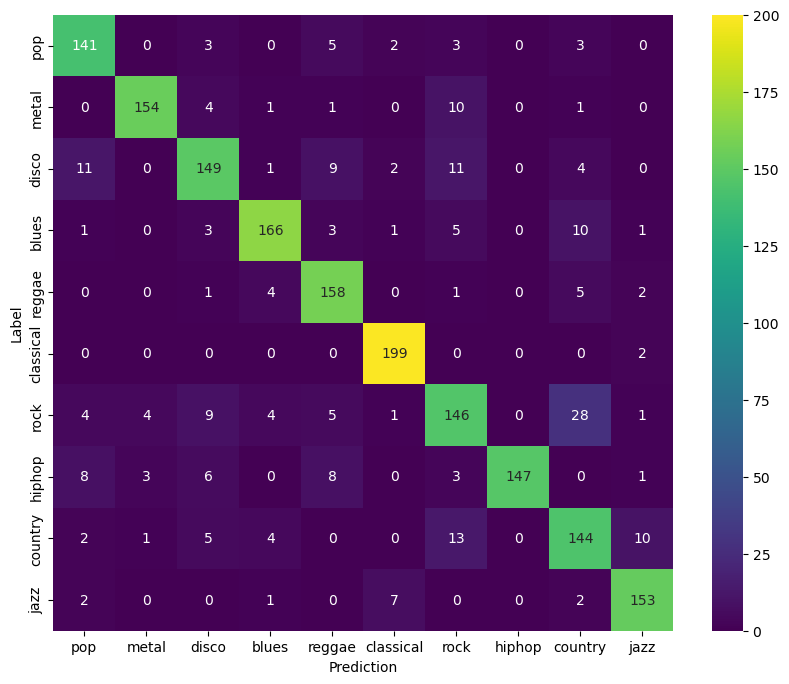

In [18]:
y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(model.predict(x_test), axis=1)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g', ax=ax, cmap="viridis", vmax=200)
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
plt.savefig("../png/cnn64_confmatrix.png", dpi=150)
plt.show()

In [19]:
model.save('../models/model1')

INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


In [67]:
model = tf.keras.models.load_model('../models/model1')

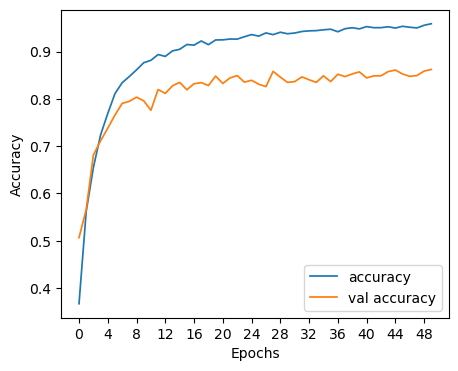

In [20]:
epochs = 50
hist_acc = history.history['accuracy'] + history2.history['accuracy']
hist_val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(epochs), hist_acc, label='accuracy', lw=1.25)
ax.plot(range(epochs), hist_val_acc, label='val accuracy', lw=1.25)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_xticks([i for i in range(0, epochs+1,4)])
ax.legend()
plt.savefig("../png/cnn64_acc_epochs.png", dpi=150)

plt.show()

In [53]:
#song_file,sr = read_sample('./data/others/Take_Me_Home_t.wav') 
song_file,sr = read_sample('./data/genres_original/blues/blues.00000.wav') 

In [34]:
listen_sample(song_file,22050)

In [65]:
def pad_mel(mel, input_shape):
    input_length = input_shape[2]
    if mel.shape[1] == input_length:
        return mel

    elif mel.shape[1] > input_length:
        mel = mel[:,:input_length]
    else:
        mel = np.pad(mel, (0, max(0, mel - len(mel))))
    return mel
def value_predict(sample, sr):
    mel = lb.feature.melspectrogram(sample, sr)
    spect = lb.power_to_db(mel, ref=1.0)
    norm_spect = normalize(spect)
    input_shape = model.layers[0].output_shape[0]

    x = pad_mel(norm_spect, input_shape)
    x = np.reshape(x, (1, input_shape[1], input_shape[2], input_shape[3]))
    
    y_pred = model.predict(x)
    return y_pred

In [66]:
value_predict(song_file, sr)

/var/folders/c2/91ntt7r91zq873dpkq9k1cxh0000gn/T/ipykernel_81829/3815809743.py:12: FutureWarning: Pass y=[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = lb.feature.melspectrogram(sample, sr)


array([[ 0.00109615,  0.00539104, -0.00500673, ...,  0.01363447,
         0.01416541,  0.0489056 ],
       [ 0.00684737,  0.01223822,  0.01547411, ...,  0.02013187,
         0.03007766,  0.03529524],
       [-0.01059075, -0.00923688,  0.01145376, ...,  0.01364407,
         0.03863768,  0.03861573],
       ...,
       [-0.02781287, -0.02781287, -0.02781287, ..., -0.02781287,
        -0.02781287, -0.02647567],
       [-0.02781089, -0.02781089, -0.02781089, ..., -0.02781089,
        -0.02781089, -0.02663378],
       [-0.02781084, -0.02781084, -0.02781084, ..., -0.02781084,
        -0.02781084, -0.02669843]], dtype=float32)